# Import necessary modules

In [1]:
!pip install -U imbalanced-learn
!pip install gensim

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from imblearn.under_sampling import RandomUnderSampler

# gensim
import gensim
from gensim.models import Word2Vec

# nltk
from nltk import sent_tokenize, word_tokenize

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)


# Handle Imbalanced Dataset

## Exploratory Data Analysis

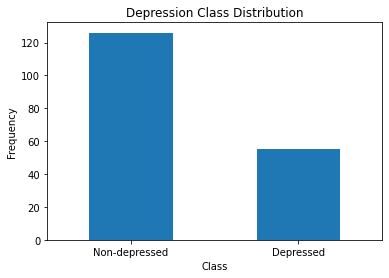

The ratio of negative to positive cases is 2.29.


In [2]:
df = pd.read_csv("../../data/clean_compiled_transcripts.csv")

count_classes = pd.value_counts(df.PHQ_Binary)
count_classes.plot(kind = 'bar', rot=0)
labels = ["Non-depressed", "Depressed"]

plt.title("Depression Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

print(f"The ratio of negative to positive cases is {round(count_classes[0] / count_classes[1], 2)}.")

Clearly, the dataset is highly imbalanced and is likely to result in poor performance. We should strive for 50:50 during training.

## Load pretrained vector embeddings

In [3]:
if not Path('./GoogleNews-vectors-negative300.bin.gz').exists():
    !wget -P ./ "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [4]:
%%time

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)
print('Model loaded')

Model loaded
CPU times: user 48.9 s, sys: 5.92 s, total: 54.8 s
Wall time: 1min 5s


In [5]:
# averaging the word vectors per document

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    # for each word in the list of words
    for word in words:
        # if the words are already vectors, then just append them
        if isinstance(word, np.ndarray):
            mean.append(word)
        # if not: first get the vector embedding for the words
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        # error handling in case mean cannot be calculated
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)
    
    # use gensim's method to calculate the mean of all the words appended to mean list
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list])

## Tokenization 

In [6]:
def w2v_tokenize_text(text):
    # create tokens, a list of words, for each post. This function will do some cleaning based on English language
    tokens = []
    for sent in sent_tokenize(text, language='english'):
        for word in word_tokenize(sent, language='english'):
            tokens.append(word)
    return tokens

tokenized = df.apply(lambda r: w2v_tokenize_text(r['Transcript']), axis=1).values

## Split the dataset 

In [7]:
X = word_averaging_list(wv, tokenized)
y = df.PHQ_Binary.to_numpy()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  del sys.path[0]


In [8]:
RANDOM_STATE = 42 # lucky number

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

X_train_val.shape, X_test.shape

((144, 300), (37, 300))

### Undersampling
We will be using undersampling techniques instead of oversampling because we are not sure of the newly generated data points.

In [9]:
# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train_val, y_train_val = us.fit_sample(X_train_val, y_train_val)

# More preprocessing

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. Hence we will focus on `f1 score` and `recall` for the positive class.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [10]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## k cross 

In [11]:
def k_cross(model, X=X_train_val, y=y_train_val, k=10, n=1, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

## Evaluate model

In [12]:
def evaluate_model(model):
    model.fit(X_train_val, y_train_val)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Logistic Regression 

In [13]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"power: {i}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"power: {i}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_logreg_f1_model, best_logreg_recall_model = find_best_logreg_model(6)

power: 0: f1 = 0.33069264069264065 > best f1 = -1
power: 0: recall = 0.62 > best recall = -1
power: 1: f1 = 0.500981240981241 > best f1 = 0.33069264069264065
power: 1: recall = 0.63 > best recall = 0.62
power: 2: f1 = 0.5839177489177488 > best f1 = 0.500981240981241
power: 2: recall = 0.6716666666666666 > best recall = 0.63
power: 3: f1 = 0.5911796536796536 > best f1 = 0.5839177489177488
power: 3: recall = 0.6841666666666667 > best recall = 0.6716666666666666


[1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.7167832167832169
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        26
           1       0.47      0.82      0.60        11

    accuracy                           0.68        37
   macro avg       0.68      0.72      0.66        37
weighted avg       0.77      0.68      0.69        37

Confusion Matrix: 
 [[16 10]
 [ 2  9]]


LogisticRegression(C=1000, n_jobs=3)

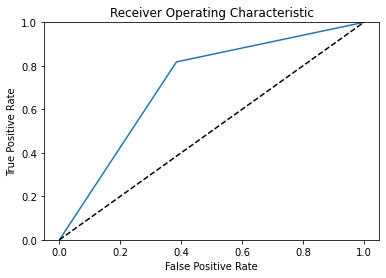

In [14]:
# Based on f1
evaluate_model(best_logreg_f1_model)

[1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.7167832167832169
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        26
           1       0.47      0.82      0.60        11

    accuracy                           0.68        37
   macro avg       0.68      0.72      0.66        37
weighted avg       0.77      0.68      0.69        37

Confusion Matrix: 
 [[16 10]
 [ 2  9]]


LogisticRegression(C=1000, n_jobs=3)

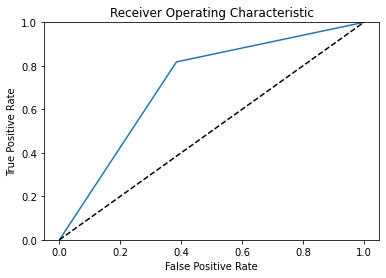

In [15]:
# Based on recall
evaluate_model(best_logreg_recall_model)

## Decision Tree

In [16]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

depth: 1, leaf: 1: f1 = 0.2972438672438672 > best f1 = -1
depth: 1, leaf: 1: recall = 0.28500000000000003 > best recall = -1
depth: 1, leaf: 21: f1 = 0.3143867243867243 > best f1 = 0.2972438672438672
depth: 1, leaf: 21: recall = 0.335 > best recall = 0.28500000000000003
depth: 1, leaf: 24: f1 = 0.35883116883116883 > best f1 = 0.3143867243867243
depth: 1, leaf: 24: recall = 0.3725 > best recall = 0.335
depth: 1, leaf: 27: f1 = 0.38264069264069256 > best f1 = 0.35883116883116883
depth: 1, leaf: 27: recall = 0.3975 > best recall = 0.3725
depth: 1, leaf: 28: f1 = 0.40573593073593067 > best f1 = 0.38264069264069256
depth: 1, leaf: 28: recall = 0.44750000000000006 > best recall = 0.3975
depth: 2, leaf: 1: f1 = 0.5401587301587302 > best f1 = 0.40573593073593067
depth: 2, leaf: 1: recall = 0.6233333333333333 > best recall = 0.44750000000000006
depth: 2, leaf: 7: recall = 0.6358333333333334 > best recall = 0.6233333333333333
depth: 2, leaf: 8: f1 = 0.5827167277167277 > best f1 = 0.5401587301587

[0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.6136363636363636
              precision    recall  f1-score   support

           0       0.81      0.50      0.62        26
           1       0.38      0.73      0.50        11

    accuracy                           0.57        37
   macro avg       0.60      0.61      0.56        37
weighted avg       0.68      0.57      0.58        37

Confusion Matrix: 
 [[13 13]
 [ 3  8]]


DecisionTreeClassifier(max_depth=2, min_samples_leaf=16, random_state=42)

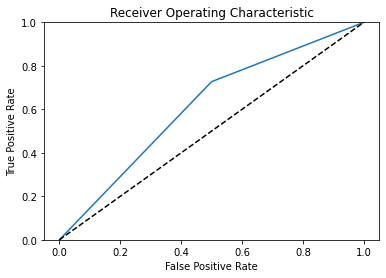

In [17]:
# Based on f1
evaluate_model(best_tree_f1_model)

[0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.6520979020979021
              precision    recall  f1-score   support

           0       0.83      0.58      0.68        26
           1       0.42      0.73      0.53        11

    accuracy                           0.62        37
   macro avg       0.63      0.65      0.61        37
weighted avg       0.71      0.62      0.64        37

Confusion Matrix: 
 [[15 11]
 [ 3  8]]


DecisionTreeClassifier(max_depth=2, min_samples_leaf=12, random_state=42)

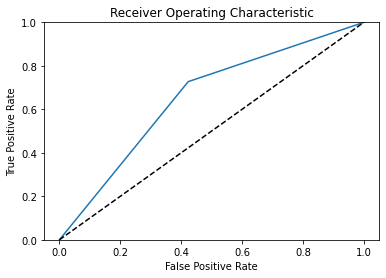

In [18]:
# Based on recall
evaluate_model(best_tree_recall_model)

## Random Forest

In [19]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(30)

estimator: 1: f1 = 0.5194444444444444 > best f1 = -1
estimator: 1: recall = 0.5316666666666666 > best recall = -1
estimator: 5: recall = 0.6058333333333333 > best recall = 0.5316666666666666
estimator: 9: recall = 0.6233333333333333 > best recall = 0.6058333333333333
estimator: 19: f1 = 0.5233122433122432 > best f1 = 0.5194444444444444
estimator: 21: f1 = 0.5738494838494839 > best f1 = 0.5233122433122432
estimator: 21: recall = 0.7058333333333333 > best recall = 0.6233333333333333
estimator: 25: f1 = 0.575992340992341 > best f1 = 0.5738494838494839
estimator: 27: f1 = 0.582052947052947 > best f1 = 0.575992340992341
estimator: 29: f1 = 0.6058624708624708 > best f1 = 0.582052947052947
estimator: 29: recall = 0.7474999999999999 > best recall = 0.7058333333333333


[0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.6066433566433566
              precision    recall  f1-score   support

           0       0.79      0.58      0.67        26
           1       0.39      0.64      0.48        11

    accuracy                           0.59        37
   macro avg       0.59      0.61      0.57        37
weighted avg       0.67      0.59      0.61        37

Confusion Matrix: 
 [[15 11]
 [ 4  7]]


RandomForestClassifier(n_estimators=29, random_state=42)

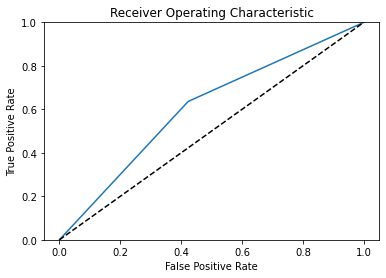

In [20]:
# Based on f1
evaluate_model(best_forest_f1_model)

[0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.6066433566433566
              precision    recall  f1-score   support

           0       0.79      0.58      0.67        26
           1       0.39      0.64      0.48        11

    accuracy                           0.59        37
   macro avg       0.59      0.61      0.57        37
weighted avg       0.67      0.59      0.61        37

Confusion Matrix: 
 [[15 11]
 [ 4  7]]


RandomForestClassifier(n_estimators=29, random_state=42)

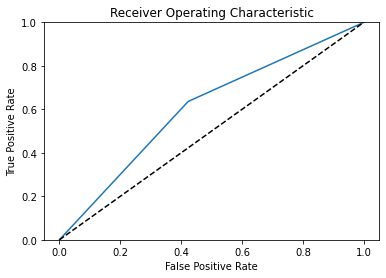

In [21]:
# Based on recall
evaluate_model(best_forest_recall_model)

## SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 123 tasks      | elapsed:    0.6s


[0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.5681818181818181
              precision    recall  f1-score   support

           0       0.76      0.50      0.60        26
           1       0.35      0.64      0.45        11

    accuracy                           0.54        37
   macro avg       0.56      0.57      0.53        37
weighted avg       0.64      0.54      0.56        37

Confusion Matrix: 
 [[13 13]
 [ 4  7]]
Best SVM parameters: {'C': 10, 'degree': 4, 'kernel': 'poly'}


[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.8s finished


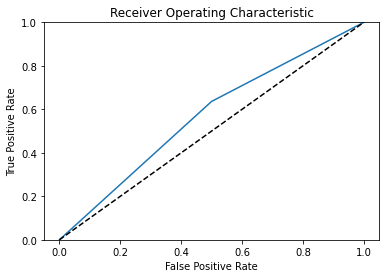

In [22]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")